In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pydot
from tensorflow.keras.utils import plot_model
import pc  # custom module

# Check CUDA support
if len(tf.config.list_physical_devices("GPU")) > 0:
    print("CUDA enabled.")
else:
    print("CUDA not enabled.")

# Path to dataset
data_folder = "/app/data"
# Training parameters
EP = 100
BS = 64
# Image resolution
RES = (224, 224)
# Random seed
SEED = 42

# Enable automatic mixed precision (not compatible with my GPU GeForce GTX 1060 6GB)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

CUDA enabled.


In [2]:
!ls /app/data

 Abra		     Dugtrio	  Jynx	       Nidorino    Seadra
 Aerodactyl	     Eevee	  Kabuto       Ninetales   Seaking
 Alakazam	     Ekans	  Kabutops     Oddish	   Seel
'Alolan Sandslash'   Electabuzz   Kadabra      Omanyte	   Shellder
 Arbok		     Electrode	  Kakuna       Omastar	   Slowbro
 Arcanine	     Exeggcute	  Kangaskhan   Onix	   Slowpoke
 Articuno	     Exeggutor	  Kingler      Paras	   Snorlax
 Beedrill	     Farfetchd	  Koffing      Parasect    Spearow
 Bellsprout	     Fearow	  Krabby       Persian	   Squirtle
 Blastoise	     Flareon	  Lapras       Pidgeot	   Starmie
 Bulbasaur	     Gastly	  Lickitung    Pidgeotto   Staryu
 Butterfree	     Gengar	  Machamp      Pidgey	   Tangela
 Caterpie	     Geodude	  Machoke      Pikachu	   Tauros
 Chansey	     Gloom	  Machop       Pinsir	   Tentacool
 Charizard	     Golbat	  Magikarp     Poliwag	   Tentacruel
 Charmander	     Goldeen	  Magmar       Poliwhirl   Vaporeon
 Charmeleon	     Golduck	  Magnemite    Poliwrath   Venomoth
 Clefable	     G

In [3]:
data_dict = pc.create_dataset(
    data_folder,
    epochs=EP,
    batch_size=BS,
    res=RES,
    seed=SEED,
)

In [4]:
train_dataset = data_dict["train_dataset"]
val_dataset = data_dict["val_dataset"]
test_dataset = data_dict["test_dataset"]
train_len = data_dict["train_len"]
val_len = data_dict["val_len"]
test_len = data_dict["test_len"]
label_encoder = data_dict["label_encoder"]

print(f"Number of training samples: {train_len}")
print(f"Number of validation samples: {val_len}")
print(f"Number of test samples: {test_len}")

Number of training samples: 5471
Number of validation samples: 594
Number of test samples: 594


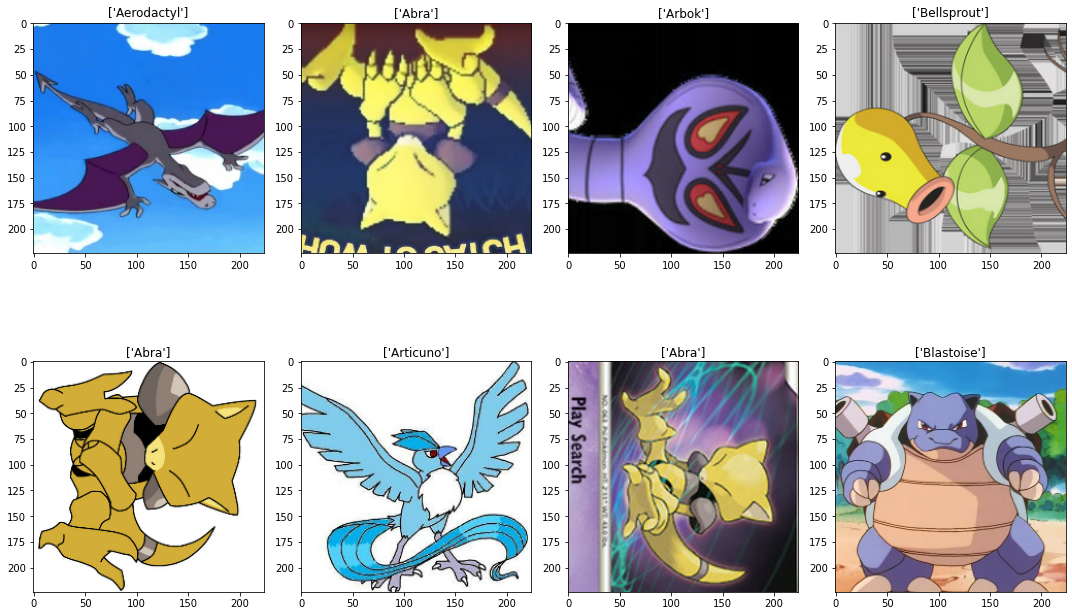

In [5]:
plt.figure(figsize=(15, 10))

# Iterate over batches
for (image_batch, label_batch) in train_dataset:
    # Iterate over elements in batch
    for i, (image, label) in enumerate(zip(image_batch[:8], label_batch[:8])):
        plt.subplot(2, 4, i + 1)
        plt.title(label_encoder.inverse_transform([label]))
        plt.imshow((255 * image.numpy()).astype(np.uint8))
    break

plt.tight_layout()
plt.show()

Training: done
Validation: done
Test: done


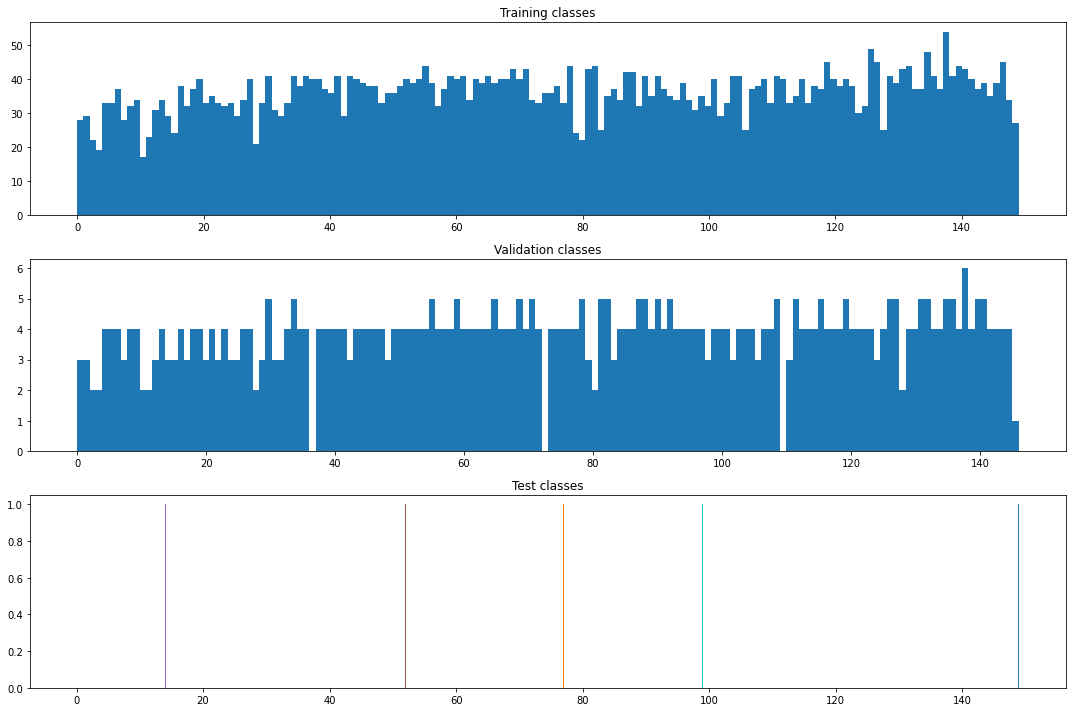

In [6]:
train_labels = []
train_it = iter(train_dataset)
for i in range(train_len // BS):
    (_, label_batch) = next(train_it)
    for label in label_batch:
        train_labels.append(label.numpy())
print("Training: done")
        
val_labels = []
val_it = iter(val_dataset)
for i in range(val_len // BS):
    (_, label_batch) = next(val_it)
    for label in label_batch:
        val_labels.append(label.numpy())
print("Validation: done")

test_labels = []
test_it = iter(test_dataset)
for i, (_, label) in enumerate(test_it):
    test_labels.append(label.numpy())
print("Test: done")

plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.hist(train_labels, bins=150)
plt.title("Training classes")
plt.subplot(3, 1, 2)
plt.hist(val_labels, bins=150)
plt.title("Validation classes")
plt.subplot(3, 1, 3)
plt.hist(test_labels, bins=150)
plt.title("Test classes")
plt.tight_layout()
plt.show()

Model: "Pokemon-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
re_lu_7 (ReLU)               (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32) 

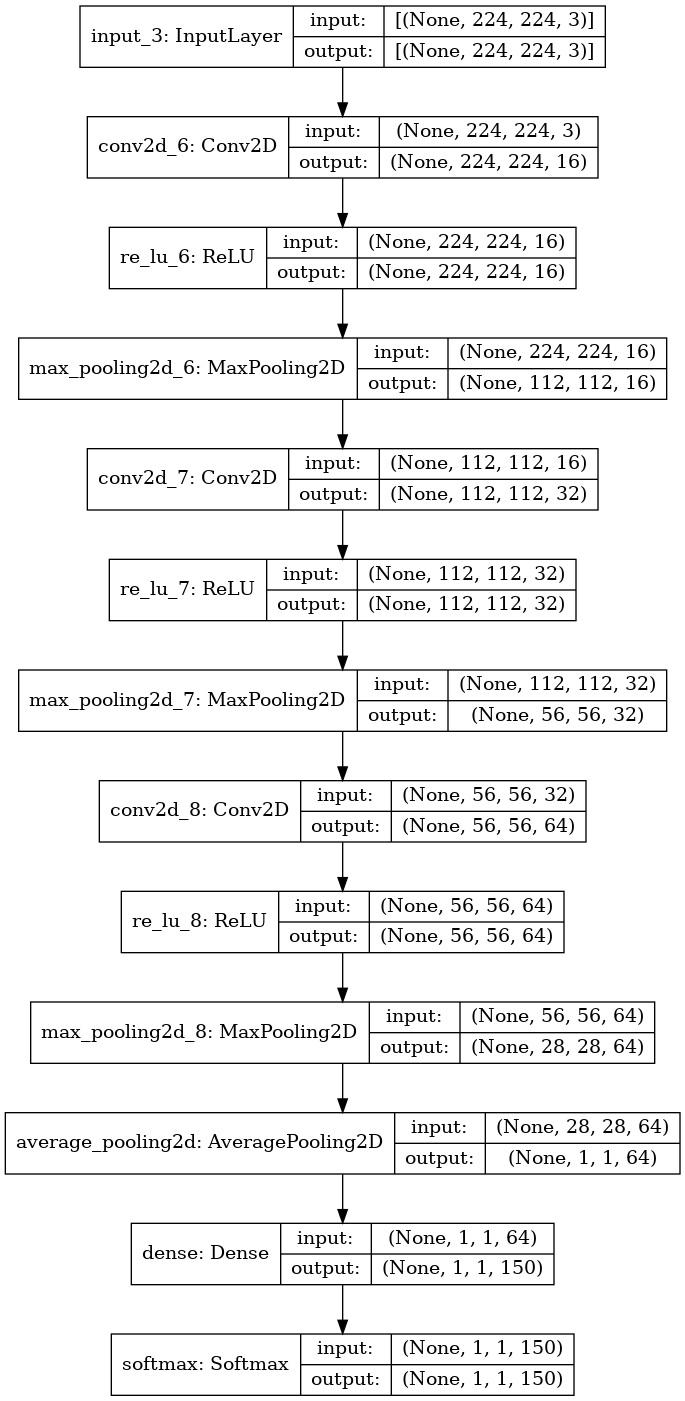

In [9]:
model = pc.create_model(n_conv=3, use_bn=False, res=RES)
model.summary()
plot_model(model, show_shapes=True)

In [10]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=EP,
    callbacks=[callback],
    steps_per_epoch=train_len // BS,
    validation_data=val_dataset,
    validation_steps=val_len // BS
)

Epoch 1/100
85/85 [==============================] - 14s 69ms/step - loss: 5.0383 - accuracy: 0.0049 - val_loss: 5.0105 - val_accuracy: 0.0069
Epoch 2/100
85/85 [==============================] - 6s 67ms/step - loss: 5.0171 - accuracy: 0.0063 - val_loss: 5.0098 - val_accuracy: 0.0069
Epoch 3/100
85/85 [==============================] - 6s 68ms/step - loss: 5.0163 - accuracy: 0.0020 - val_loss: 5.0091 - val_accuracy: 0.0069
Epoch 4/100
85/85 [==============================] - 6s 68ms/step - loss: 5.0156 - accuracy: 0.0024 - val_loss: 5.0084 - val_accuracy: 0.0069
Epoch 5/100
85/85 [==============================] - 6s 68ms/step - loss: 5.0149 - accuracy: 0.0067 - val_loss: 5.0078 - val_accuracy: 0.0071
Epoch 6/100
85/85 [==============================] - 6s 67ms/step - loss: 5.0149 - accuracy: 0.0080 - val_loss: 5.0052 - val_accuracy: 0.0088
Epoch 7/100
85/85 [==============================] - 6s 67ms/step - loss: 4.9802 - accuracy: 0.0035 - val_loss: 5.0328 - val_accuracy: 0.0069
Epoch

85/85 [==============================] - 6s 70ms/step - loss: 4.8800 - accuracy: 0.0037 - val_loss: 4.9364 - val_accuracy: 0.0063
Epoch 59/100
85/85 [==============================] - 6s 70ms/step - loss: 4.9056 - accuracy: 0.0078 - val_loss: 4.9131 - val_accuracy: 0.0042
Epoch 60/100
85/85 [==============================] - 6s 70ms/step - loss: 4.9104 - accuracy: 0.0092 - val_loss: 5.3292 - val_accuracy: 0.0019
Epoch 61/100
85/85 [==============================] - 6s 68ms/step - loss: 4.9689 - accuracy: 0.0092 - val_loss: 4.9170 - val_accuracy: 0.0089
Epoch 62/100
85/85 [==============================] - 6s 68ms/step - loss: 4.9200 - accuracy: 0.0080 - val_loss: 4.8052 - val_accuracy: 0.0085
Epoch 63/100
85/85 [==============================] - 6s 68ms/step - loss: 4.8841 - accuracy: 0.0097 - val_loss: 4.7805 - val_accuracy: 0.0078
Epoch 64/100
85/85 [==============================] - 6s 68ms/step - loss: 4.8485 - accuracy: 0.0083 - val_loss: 4.8212 - val_accuracy: 0.0069
Epoch 65/100

In [11]:
# Save model (tensorflow standard format)
model.save("model2")

INFO:tensorflow:Assets written to: model2/assets


In [17]:
model = tf.keras.models.load_model('./model1')

In [11]:
test_dict = model.evaluate(
    test_dataset,
    steps=test_len,
    return_dict=True
)

594/594 [==============================] - 1s 2ms/step - loss: 4.7759 - accuracy: 0.0202


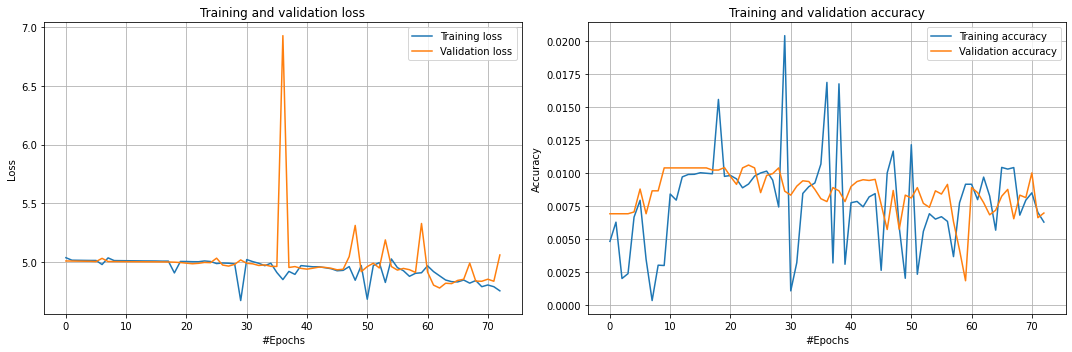

In [12]:
plt.figure(figsize=(15, 5))  # set graph dimension

# 1. First graph

plt.subplot(1, 2, 1)  # creates 1 subplot out of 2

plt.title("Training and validation loss")
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("#Epochs")
plt.ylabel("Loss")
plt.grid()

# 2. Second Graph

plt.subplot(1, 2, 2)  # creates 1 subplot out of 2

plt.title("Training and validation accuracy")
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.xlabel("#Epochs")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()

In [16]:
!ls

'Pokemon cards classification.ipynb'   __pycache__   model.png	 pc.py
